# Spritz MBHB search + imputation (time-domain approach)

Let's try to  replicate `MBHB-search-dev-globe.ipynb` with time-domain data and with Spritz data (MBHB-1 dataset).

E Castelli - 2022

## Table of contents

0. Settings and package import
1. Load time-domain LDC data
2. Build orthogonal TDI combinations
3. Data pre-processing before gap-imputation
4. Gap imputation with custom gaps
    1. noise-only `n` data
    2. noise + signal `n + s` data
5. Analysis of Spritz data

## 0. Settings and package import

In [1]:
# Python standard packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal
from scipy.stats import norm
import h5py
import time

In [2]:
# Custom LISA Data Analysis packages 
from ldc.lisa.noise import get_noise_model
from ldc.common import tools
from ldc.common.constants import ldc_cosmo as cosmo
from ldc.common.series import TimeSeries, FrequencySeries, TDI
from ldc.common.tools import compute_tdi_snr, window
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.lisa.noise import AnalyticNoise, get_noise_model
from ldc.waveform.lisabeta import FastBHB

import lisabeta.lisa.ldcnoise as ldcnoise
from bayesdawn import datamodel, psdmodel
import lisaorbits

MLDC modules could not be loaded.


In [3]:
# define function to print all attributes of hdf5 file recursively
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. In order to do that, we separate the effect of glitches from the effect of gaps in the Spritz data.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [4]:
# import data
fname = './data/LDC2_spritz_mbhb1_training_v1.h5'
# open file with h5py
fid = h5py.File(fname)
# print all dataset attributes
# fid.visititems(print_attrs)
cfg = dict(zip(fid["obs/config"].keys(), [v[()] for v in fid["obs/config"].values()]))

#### 1.1. Import the existing TDI datasets

- TDI dataset `obs` containing `noise + signal + artifacts` (gaps + glitches)
- TDI dataset `clean` containing `noise + signal`
- TDI dataset `sky` containing `signal`
- TDI dataset `noisefree` containing `signal + artifacts` (gaps + glitches)

In [5]:
from fillgaps import load_tdi_timeseries

In [6]:
tdidata = load_tdi_timeseries(fname = fname)
tdidata

{'obs': array([( 8899200.,  1.48846573e-16,  6.75329568e-17, -3.88519717e-16),
        ( 8899205., -4.42617579e-16, -1.11055482e-16,  5.28572415e-16),
        ( 8899210., -7.98086872e-16,  7.99285081e-16, -1.47198918e-15),
        ...,
        (11577585., -9.29825703e-21, -6.92159645e-21,  7.19465308e-21),
        (11577590.,  5.70018992e-21, -9.60595627e-22, -4.94114882e-21),
        (11577595., -4.30521190e-21,  8.29781591e-21,  2.00536091e-20)],
       dtype=[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]),
 'clean': array([( 8899200.,  1.48846530e-16,  6.75330625e-17, -3.88519776e-16),
        ( 8899205., -4.42617614e-16, -1.11055377e-16,  5.28572349e-16),
        ( 8899210., -7.98086900e-16,  7.99285186e-16, -1.47198925e-15),
        ...,
        (11577585., -9.25155200e-21, -7.01214434e-21,  7.23238271e-21),
        (11577590.,  5.74426785e-21, -1.04391992e-21, -4.90782302e-21),
        (11577595., -4.26376105e-21,  8.22171527e-21,  2.00825311e-20)],
       dtype=[('t', 

#### 1.2. Build the missing TDI dataset
- TDI dataset containing `noise`
- TDI dataset containing `noise + signal + gaps`

In [7]:
# set up dataset constant values
skip = 100 
# skipb = 100 
ndata = len(tdidata['obs'][skip:])
dt = tdidata['obs']['t'][1]-tdidata['obs']['t'][0]
tobs = ndata * dt
fs = 1.0/dt

print('skip','ndata','dt', 'fs',sep='\t',end='\n------------------------------\n')
print(skip, ndata, dt, fs,sep='\t')

skip	ndata	dt	fs
------------------------------
100	535580	5.0	0.2


#### 1.3. Plot imported data:
- Datasets containing NO noise artifacts: `n+s`, `s`, `n`
- Dataset with artifacts: `n+s+g+gl`, `n+s+g`,`s+g+gl`
    
Useful LDC-provided resources and code bits to importing Spritz data taken from here: https://gitlab.in2p3.fr/LISA/LDC/-/blob/develop/notebooks/LDC2b-Spritz.ipynb

In [8]:
256*256

65536

In [38]:
ndata//8

66947

In [39]:
len(np.linspace(tdidata['sky']['t'][skip], tdidata['sky']['t'][skip]+ndata//8*dt, ndata//8))

66947

In [53]:
# avgwin = 'nuttall'
avgwin = 'hann'
# avgwin = window(np.linspace(tdidata['sky']['t'][skip], tdidata['sky']['t'][skip]+ndata//8*dt, ndata//8))

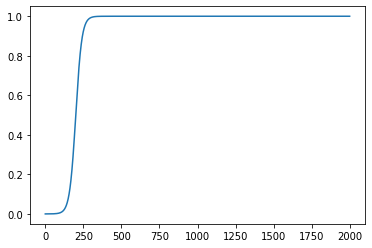

In [54]:
wint = window(tdidata['sky']['t'][skip:] - tdidata['sky']['t'][skip:][0])
plt.plot(wint[0:2000])
f, psdX =  scipy.signal.welch(wint*tdidata['sky']['X'][skip:], fs=1.0/dt, window='hann', nperseg=256*256)

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

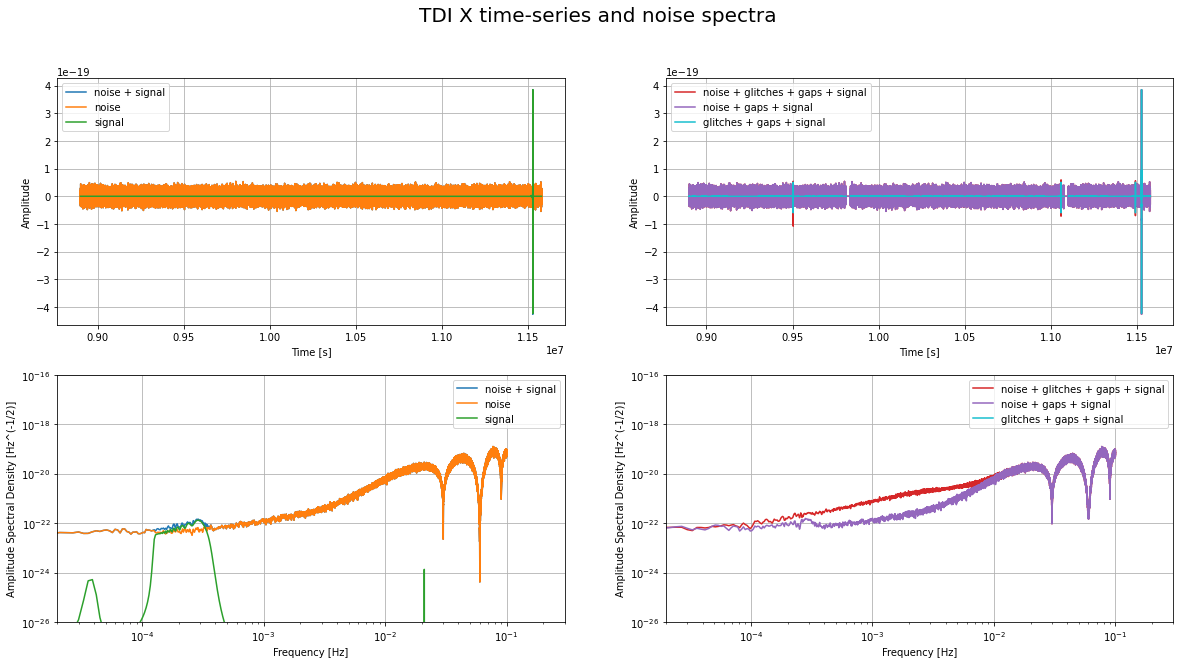

In [55]:
# plot TDI X time-series and noise spectra for all different configurations

fig, ax = plt.subplots(2, 2, figsize=(20,10))
# top left canvas
ax[0][0].plot(tdidata['clean']['t'][skip:], tdidata['clean']["X"][skip:], label = 'noise + signal')
ax[0][0].plot(tdidata['noise']['t'][skip:], tdidata['noise']["X"][skip:], label='noise')
ax[0][0].plot(tdidata['sky']['t'][skip:], tdidata['sky']["X"][skip:], label='signal')
ax[0][0].set_ylabel("Amplitude")
ax[0][0].set_xlabel("Time [s]")
ax[0][0].grid()
ax[0][0].legend()
# top right canvas
ax[0][1].plot(tdidata['obs']['t'][skip:], tdidata['obs']["X"][skip:], label='noise + glitches + gaps + signal', color='tab:red')
ax[0][1].plot(tdidata['clean_gapped']['t'][skip:], tdidata['clean_gapped']["X"][skip:], label='noise + gaps + signal', color='tab:purple')
ax[0][1].plot(tdidata['noisefree']['t'][skip:], tdidata['noisefree']["X"][skip:], label='glitches + gaps + signal', color='tab:cyan')
ax[0][1].set_ylabel("Amplitude")
ax[0][1].set_xlabel("Time [s]")
ax[0][1].grid()
ax[0][1].legend()
# bottom left canvas
f, psdX =  scipy.signal.welch(wint*tdidata['clean']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//8)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise + signal')
f, psdX =  scipy.signal.welch(wint*tdidata['noise']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//8)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise')
f, psdX =  scipy.signal.welch(wint*tdidata['sky']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//8)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'signal')
ax[1][0].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][0].set_xlabel("Frequency [Hz]")
ax[1][0].grid()
ax[1][0].legend()
ax[1][0].set_ylim([1e-26,1e-16])
ax[1][0].set_xlim([2e-5,0.3])

# bottom right canvas
tdix_wo_nan = tdidata['obs']["X"].copy()
tdix_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(wint*tdix_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//8)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + glitches + gaps + signal', color='tab:red')

tdigapped_wo_nan = tdidata['clean_gapped']["X"].copy()
tdigapped_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(wint*tdigapped_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//8)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + gaps + signal', color='tab:purple')

tdinoise_wo_nan = tdidata['noisefree']["X"].copy()
tdinoise_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(wint*tdinoise_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//8)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'glitches + gaps + signal', color='tab:cyan')

ax[1][1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][1].set_xlabel("Frequency [Hz]")
ax[1][1].grid()
ax[1][1].legend()
ax[1][1].set_ylim([1e-26,1e-16])
ax[1][1].set_xlim([2e-5,0.3])

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)
# fig.tight_layout()

In [56]:
import sys
sys.path.append('../../lisa-software/LDC/data_generation/sangria')
from pipeviewer import PipeViewer

release_dir = "data"
pv = PipeViewer.spritz(release_dir)

In [57]:
# plt.figure(figsize=(15,5));pv.plot_noise_psd('mbhb1')

#### 1.5 Let's take a look at the impact of gaps on the noise spectrum

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

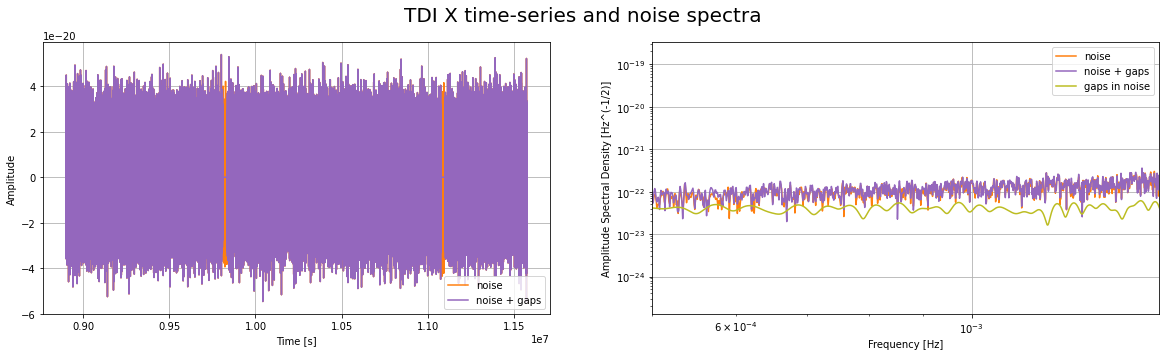

In [15]:
# plot TDI X
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# top left canvas
ax[0].plot(tdidata['noise']['t'][skip:], tdidata['noise']["X"][skip:], label='noise', color='tab:orange')
ax[0].plot(tdidata['noise_gapped']['t'][skip:], tdidata['noise_gapped']["X"][skip:], label='noise + gaps', color='tab:purple')
# ax[0].plot(tdidata['noise_gapped']['t'][skip:], gapdiff, label='noise + gaps + signal', color='tab:blue')
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Time [s]")
ax[0].grid()
ax[0].legend()
# top right canvas
f, psdX =  scipy.signal.welch(tdidata['noise']["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdX),label = 'noise', color='tab:orange')

tdinoisegapped_wo_nan = tdidata['noise_gapped']["X"].copy()
tdinoisegapped_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdXgap =  scipy.signal.welch(tdinoisegapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdXgap),label = 'noise + gaps', color='tab:purple')

gapdiff = tdinoisegapped_wo_nan[skip:] - tdidata['noise']["X"][skip:]
f, psddiff =  scipy.signal.welch(gapdiff, fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psddiff),label = 'gaps in noise', color='tab:olive')
ax[1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].grid()
ax[1].set_xlim([0.5e-3, 1.5e-3])
ax[1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)

#### 1.6. Let's take a look at the impact of gaps on the signal spectrum

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

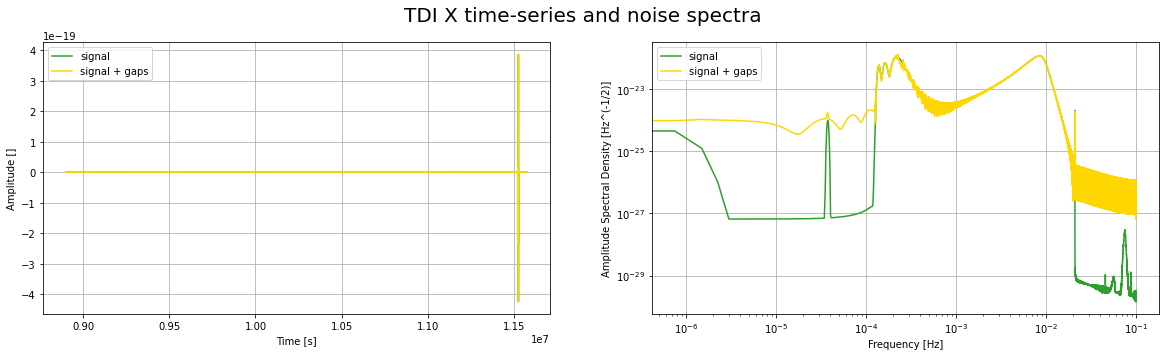

In [16]:
# plot TDI X
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# top left canvas
ax[0].plot(tdidata['sky']['t'][skip:], tdidata['sky']["X"][skip:], label='signal', color='tab:green')
ax[0].plot(tdidata['sky_gapped']['t'][skip:], tdidata['sky_gapped']["X"][skip:], label='signal + gaps', color='gold')
# ax[0].plot(tdidata['noise_gapped']['t'][skip:], gapdiff, label='noise + gaps + signal', color='tab:blue')
ax[0].set_ylabel("Amplitude []")
ax[0].set_xlabel("Time [s]")
ax[0].grid()
ax[0].legend()
# top right canvas
f, psdX =  scipy.signal.welch(tdidata['sky']["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdX),label = 'signal', color='tab:green')

tdiskygapped_wo_nan = tdidata['sky_gapped']["X"].copy()
tdiskygapped_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdXgap =  scipy.signal.welch(tdiskygapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdXgap),label = 'signal + gaps', color='gold')
ax[1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].grid()
ax[1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)

## 2. Build orthogonal TDI combinations

### 2.1. Build orthogonal TDI combinations for `n+s` data. 

Check that explicit evaluation of orthogonal TDI combinations is equivalent to evaluation inside LDC functions.

In [17]:
from fillgaps import build_orthogonal_tdi

In [18]:
datans = build_orthogonal_tdi(tdidata['clean'])

Compare my evaluation to LDC conversion function, just to be on the safe side of things.

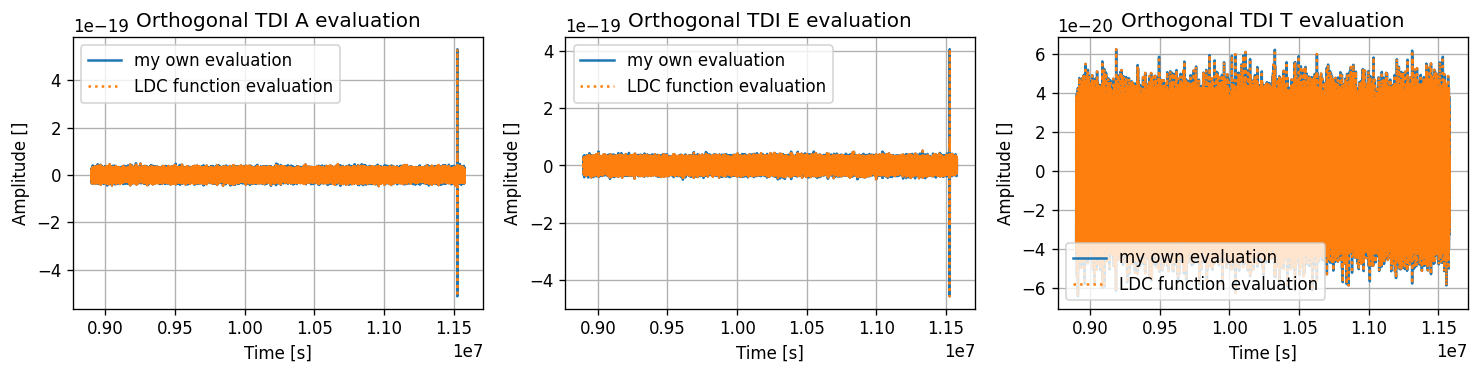

In [19]:
clean_orto = TDI.load(fname, name="clean/tdi")
# clean_orto
clean_orto.XYZ2AET()

fig, ax = plt.subplots(1,3, figsize=(15,3),dpi=120)
for tdi in datans.dtype.names[1:]:
    ax[datans.dtype.names[1:].index(tdi)].set_title('Orthogonal TDI {tdi} evaluation'.format(tdi=tdi))
    ax[datans.dtype.names[1:].index(tdi)].plot(datans['t'], datans[tdi], label = 'my own evaluation')
    ax[datans.dtype.names[1:].index(tdi)].plot(clean_orto[tdi].coords['t'][skip:],clean_orto[tdi].values[skip:], ls =':', label = 'LDC function evaluation')
    ax[datans.dtype.names[1:].index(tdi)].set_xlabel('Time [s]')
    ax[datans.dtype.names[1:].index(tdi)].set_ylabel('Amplitude []')
    ax[datans.dtype.names[1:].index(tdi)].grid()
    ax[datans.dtype.names[1:].index(tdi)].legend()

### 2.2. Build orthogonal TDI combinations for `s`, `n`, `n+s+g` data. 


In [20]:
datas  = build_orthogonal_tdi(tdidata['sky'])
datan  = build_orthogonal_tdi(tdidata['noise'])
datag  = build_orthogonal_tdi(tdidata['clean_gapped'])
datang = build_orthogonal_tdi(tdidata['noise_gapped'])
dataobs = build_orthogonal_tdi(tdidata['obs'])

In [21]:
dataobs

rec.array([( 8899700., -1.41927496e-20,  8.71348349e-21,  6.29695504e-21),
           ( 8899705.,  1.09615870e-20,  7.70170468e-21,  1.77424024e-20),
           ( 8899710., -1.06405792e-20, -1.82915168e-20, -1.77697019e-20),
           ...,
           (11577585.,  1.16622486e-20,  4.79266712e-21, -5.21070188e-21),
           (11577590., -7.52456278e-21,  1.09420028e-21, -1.16367560e-22),
           (11577595.,  1.72242875e-20, -3.45882086e-22,  1.38830876e-20)],
          dtype=[('t', '<f8'), ('A', '<f8'), ('E', '<f8'), ('T', '<f8')])

### 2.3. Define useful functions 

All these will end up in a separate file afterwards.

- `fft_olap_psd`: function that evaluates PSD equivalent to `scipy.signal.welch` and also evaluates FFT at the same time
- `generate_freq_data`: function that applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
- `plot_compare_spectra_timeseries`: modified version of `lisabeta_fill_gaps.plot_compare_spectra` function that plots noise spectra and distribution of real/imag part of PSD/noise_model

### 2.4 Data quicklook
#### 2.4.1 Test PSD and FFT evaluation function

In [22]:
from fillgaps import fft_olap_psd, generate_freq_data, plot_compare_spectra_timeseries

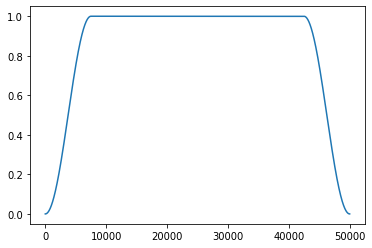

In [23]:
plt.plot(scipy.signal.windows.tukey(50000, alpha = 0.3))

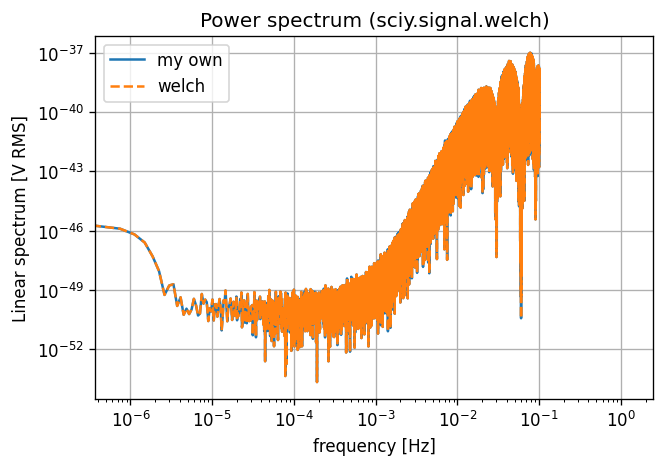

In [24]:
# Test psd and fft evaluation function
f, psdA, fft_A, _ = fft_olap_psd(datan, chan = 'T', plot = True)
# f, psdA, fft_A, _ = fft_olap_psd(datan, chan = 'A', plot = True, win = 'hanning')

#### 2.4.2 Define LISA noise model
Import noise model for Spritz data from LDC toolbox.

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


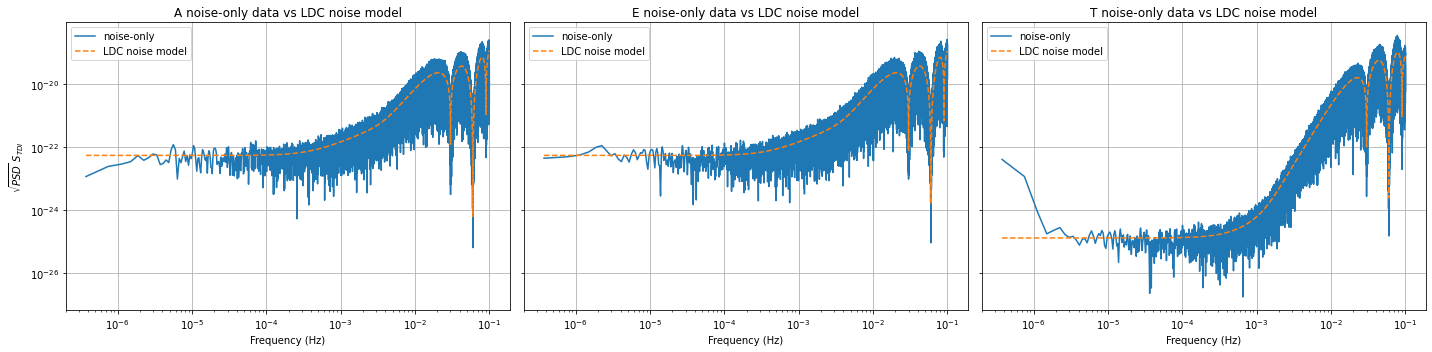

In [25]:
#Load some noise models from lisabeta
# import lisabeta.lisa.pyLISAnoise as pyLISAnoise

LISAnoise={'InstrumentalNoise': 'SciRDv1', 
           'WDbackground': False, 
           'WDduration': 0.0, 
           'lowf_add_pm_noise_f0': 0.0, 
           'lowf_add_pm_noise_alpha': 2.0}
# LISAnoise={'InstrumentalNoise': 'Proposal', 
#            'WDbackground': True, 
#            'WDduration': 3.0, 
#            'lowf_add_pm_noise_f0': 0.0, 
#            'lowf_add_pm_noise_alpha': 2.0}

# eval psd of noise data
fdatan, psddatan, fftscalefac = generate_freq_data(datan)
# noise models for A, E, T
 # Comparison with LISA Orbits
orbits = lisaorbits.KeplerianOrbits(dt=cfg['dt_orbits'], 
                                    L=cfg['nominal_arm_length'], 
                                    a=149597870700.0, 
                                    lambda1=0, 
                                    m_init1=0, 
                                    kepler_order=cfg['kepler_order'])
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan['f'], wd=0, orbits=orbits, t_obs=tobs)
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan['f'],equal_arms=False)
# plot data
fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=True)
for tdi in S.keys(): 
    ax[list(S.keys()).index(tdi)].set_title('{tdi} noise-only data vs LDC noise model'.format(tdi=tdi))
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(psddatan[tdi]), label='noise-only')
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(S[tdi]), ls='--', label='LDC noise model')
    ax[list(S.keys()).index(tdi)].set_xlabel('Frequency (Hz)')
    ax[list(S.keys()).index(tdi)].grid()
    ax[list(S.keys()).index(tdi)].legend()

ax[0].set_ylabel(r'$\sqrt{PSD}$ $S_{TDI}$')
fig.tight_layout()
# plt.suptitle('Comparison between TDI of noise-only Spritz data vs noise models');

#### 2.4.3 Plot comparison between spectra and FFT distribution

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


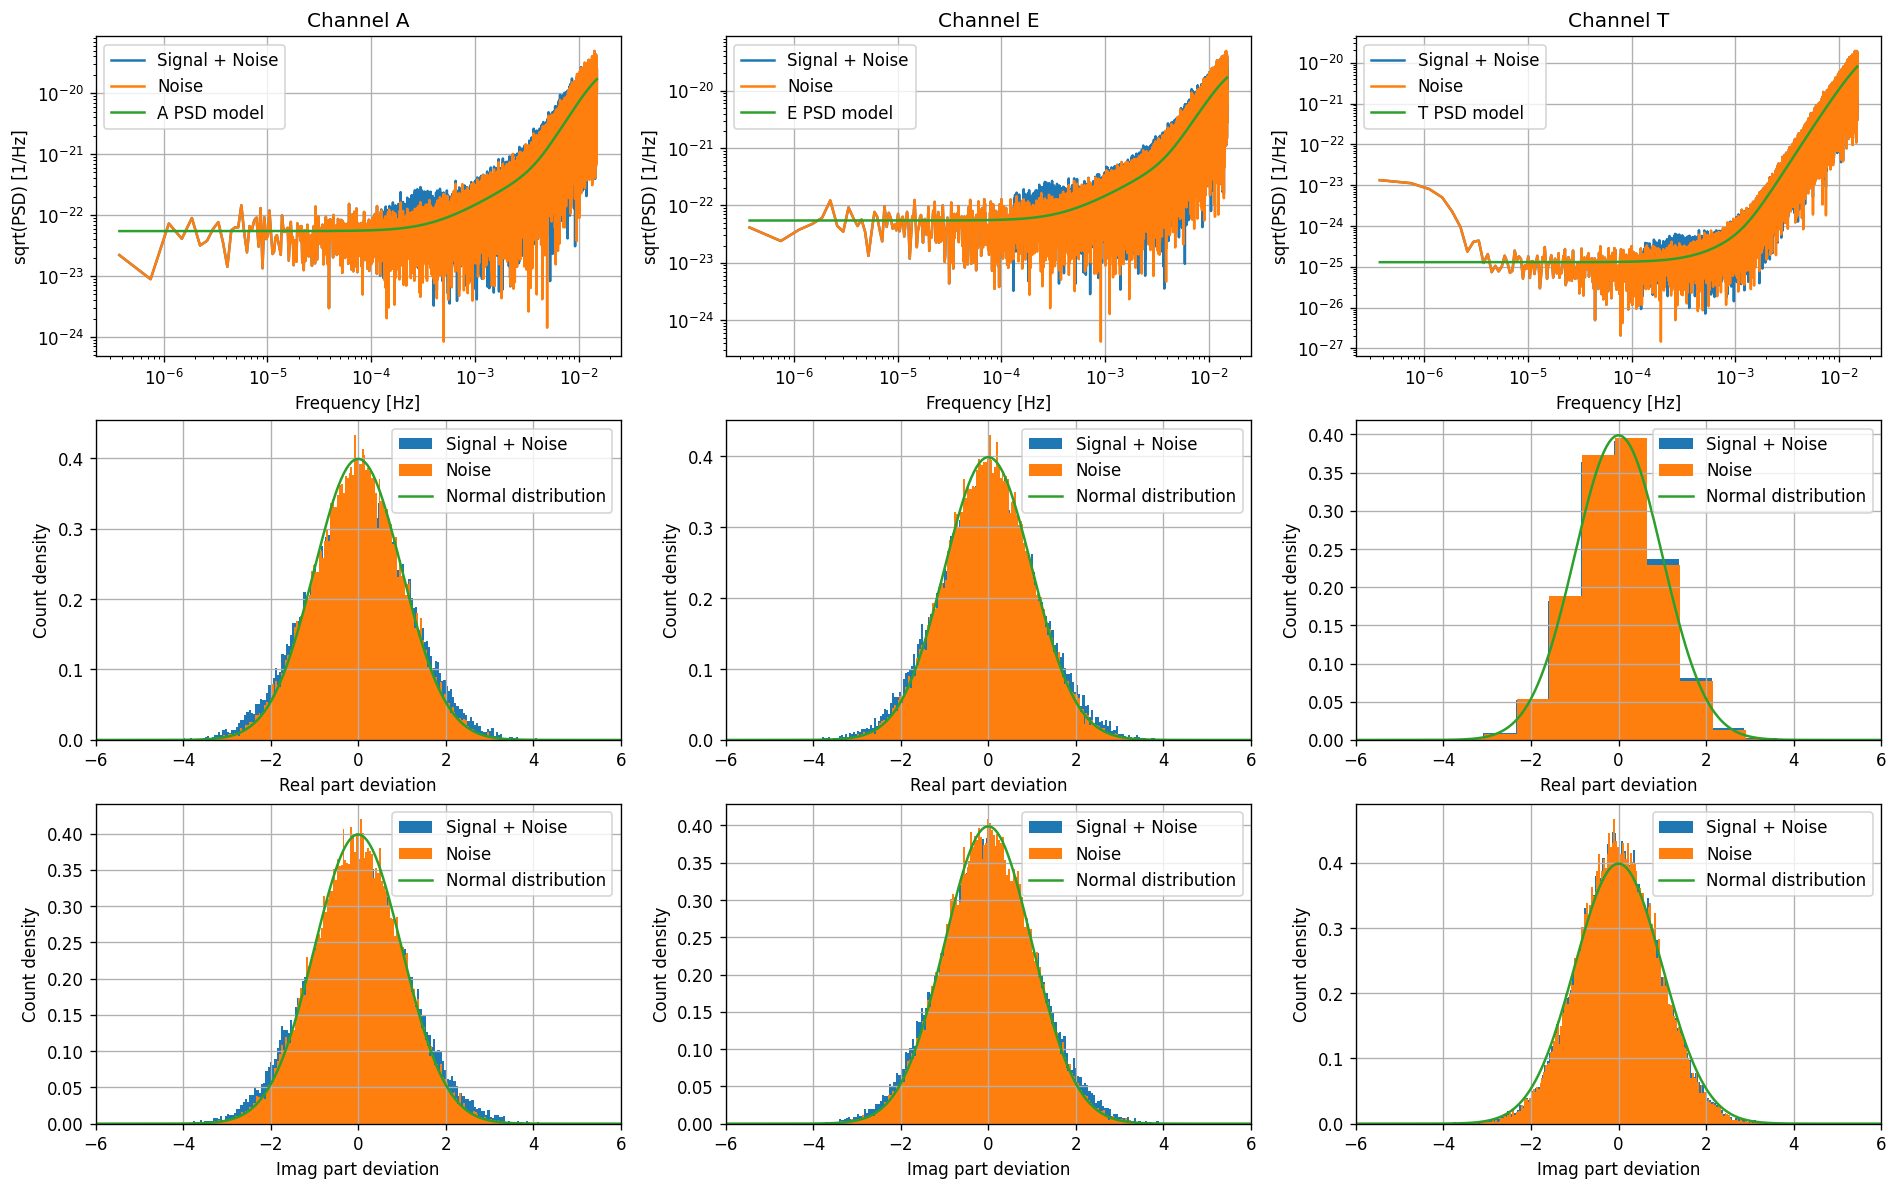

In [26]:
fmax = 1.5e-2
plot_compare_spectra_timeseries(data = [datans, datan], 
                                noise_models = [S.get(key) for key in ['A','E', 'T']], 
                                fmax = fmax)

## 3. Data pre-processing
Trying to apply the same data pre-processing treatment that has been applied to data in `MBHB_search_dev_globe.ipynb`.

We'll compare use of use downaveraged data vs full data to analyze this problem: instead of `datan` we'll use `datan_da`.

We're gonna:
- Downsample and downaverage the data to avoid aliasing
    - Avoid downsampling by selecting single samples
    - Better to be averaging neighboring points

In [27]:
def downaverage(data, factor):
    avg=[]
    # downaveraging step
    for name in data.dtype.names[:]:
        avg += [np.convolve(data[name], np.ones(factor)/factor, mode='valid')] 
#         avg += [data[name]]
    # downsampling with IIR filter to avoid aliasing
    avg[0]=avg[0][::factor]
    for i in range(1,len(avg)):
        avg[i] = scipy.signal.decimate(avg[i], factor)
 
    return np.rec.fromarrays(avg, names = data.dtype.names)

Shape of original data is (535580,) and is downaveraged down to (535580,)


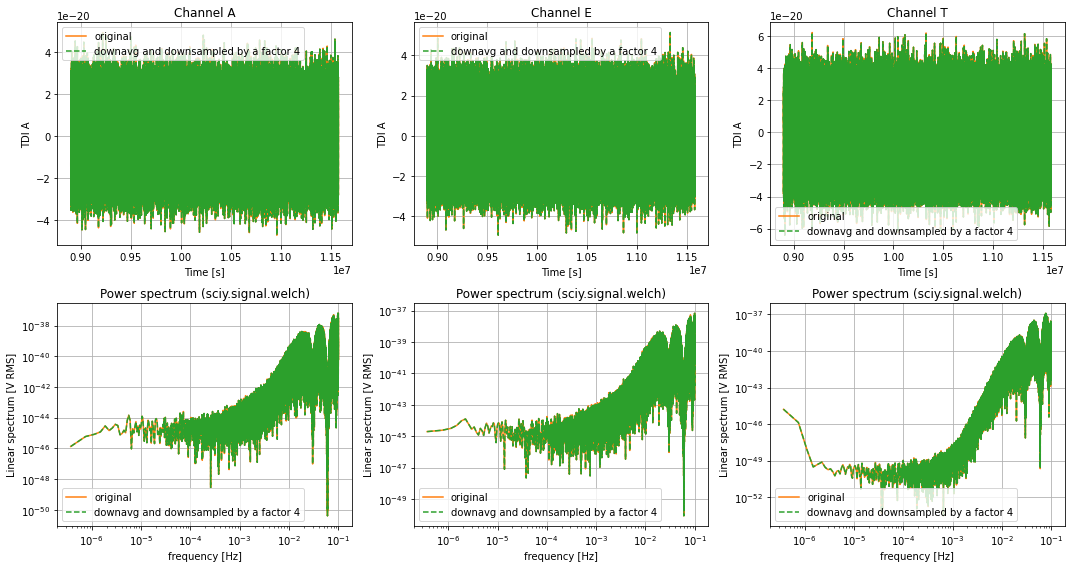

In [28]:
downfactor = 4

# downavg = downaverage(datan,downfactor)
downavg = datan

print("Shape of original data is " + str(datan.shape) + " and is downaveraged down to " + str(downavg.shape))

# fdatan, psddatan, fftscalefac = generate_freq_data(datan)
fdatan_da, psddatan_da, fftscalefac_da = generate_freq_data(downavg)

fig, ax = plt.subplots(2,3,figsize=(15,8))

for tdi in S.keys(): 
    ax[0][list(S.keys()).index(tdi)].set_title('Channel {tdi}'.format(tdi=tdi))
    ax[0][list(S.keys()).index(tdi)].plot(datan['t'],datan[tdi], label = 'original',color='tab:orange')
    ax[0][list(S.keys()).index(tdi)].plot(downavg['t'],downavg[tdi],label = 'downavg and downsampled by a factor {0:d}'.format(downfactor),ls='--', color='tab:green')
    ax[0][list(S.keys()).index(tdi)].grid()
    ax[0][list(S.keys()).index(tdi)].legend()
    ax[0][list(S.keys()).index(tdi)].set_xlabel('Time [s]')
    ax[0][list(S.keys()).index(tdi)].set_ylabel('TDI A')

    ax[1][list(S.keys()).index(tdi)].loglog(psddatan['f'], (psddatan[tdi]), label = 'original', ls='-', color='tab:orange')
    ax[1][list(S.keys()).index(tdi)].loglog(psddatan_da['f'], (psddatan_da[tdi]), label = 'downavg and downsampled by a factor {0:d}'.format(downfactor), ls='--', color='tab:green')
    ax[1][list(S.keys()).index(tdi)].set_xlabel('frequency [Hz]')
    ax[1][list(S.keys()).index(tdi)].set_ylabel('Linear spectrum [V RMS]')
    ax[1][list(S.keys()).index(tdi)].set_title('Power spectrum (sciy.signal.welch)')
    ax[1][list(S.keys()).index(tdi)].legend()
#     ax[1][list(S.keys()).index(tdi)].set_xlim([f[0], dt/2])
    ax[1][list(S.keys()).index(tdi)].grid()
fig.tight_layout()

## 4. Gap imputation on noise-only `n` data
We'll first apply imputation to noise-only `n` data, then we'll move to `n + s`. 

In [29]:
# import lisabeta_fill_gaps as fill_gaps
from fillgaps import construct_gap_mask

In [30]:
SAVE = False
n_gaps = 3
gap_length = 1000
figname = 'figures/nodownavg_'+str(n_gaps)+'gaps_'+str(gap_length)+'length'+'_psdcorrected'

Here we compare the full noise + signal dataset with the only-noise dataset, applying `LISAnoise` as noise model for the TDI noise spectra.

Note that `n + s` data do not deviate significantly from the Gaussian behavior for the orthogonal TDI combinations.

We have the expected Gaussian distribution behavior for $A$ and $E$, but not as much for $T$.

### 4.1 Data imputation with short custom gaps 


#### 4.1.1 Specify some short gaps (1000 samples) and generate gapped data
Based on the `n` data, we are going to add some gaps to this data realization.

We're going to start with 3 small gaps 20-sample 100-seconds long as in the original notebook to test the code.

In [31]:
# reset time-series information data
ndata = downavg.shape[0]
dt = downavg['t'][1]-downavg['t'][0]
fs = 1/(downavg['t'][1]-downavg['t'][0])

print('ndata','dt', 'fs',sep='\t',end='\n---------------------\n')
print(ndata, dt, fs,sep='\t')

# fdatan, psddatan, fftscalefac = generate_freq_data(datan)
# fdatan_da, psddatan_da, fftscalefac_da = generate_freq_data(downavg)

ndata	dt	fs
---------------------
535580	5.0	0.2


In [32]:
#construct gap mask
mask = np.ones(ndata)
ts = np.arange(ndata) * dt

maskinfo = construct_gap_mask(ndata,
                              n_gaps = n_gaps,
                              gap_length = gap_length,
                              verbose = True)
mask = maskinfo['mask']

Defined gaps:
  gap0 (304571:305571)
  gap1 (384314:385314)
  gap2 (446110:447110)


In [33]:
data_masked = downavg.copy()

for names in downavg.dtype.names[1:]:
    data_masked[names] = mask * downavg[names]

for i in range(len(maskinfo['starts'])):
    print('gap', i,
          ':\n\tsamples:', maskinfo['starts'][i],
          '< i <', maskinfo['ends'][i],
          '\n\tseconds:', ts[maskinfo['starts'][i]],
          '< t <', ts[maskinfo['ends'][i]])

gap 0 :
	samples: 304571 < i < 305571 
	seconds: 1522855.0 < t < 1527855.0
gap 1 :
	samples: 384314 < i < 385314 
	seconds: 1921570.0 < t < 1926570.0
gap 2 :
	samples: 446110 < i < 447110 
	seconds: 2230550.0 < t < 2235550.0


#### 4.1.2. Define function to visualize gaps in time-domain

Slightly modified version of `lisabeta_fill_gaps.view_gaps`.

In [34]:
from fillgaps import view_gaps

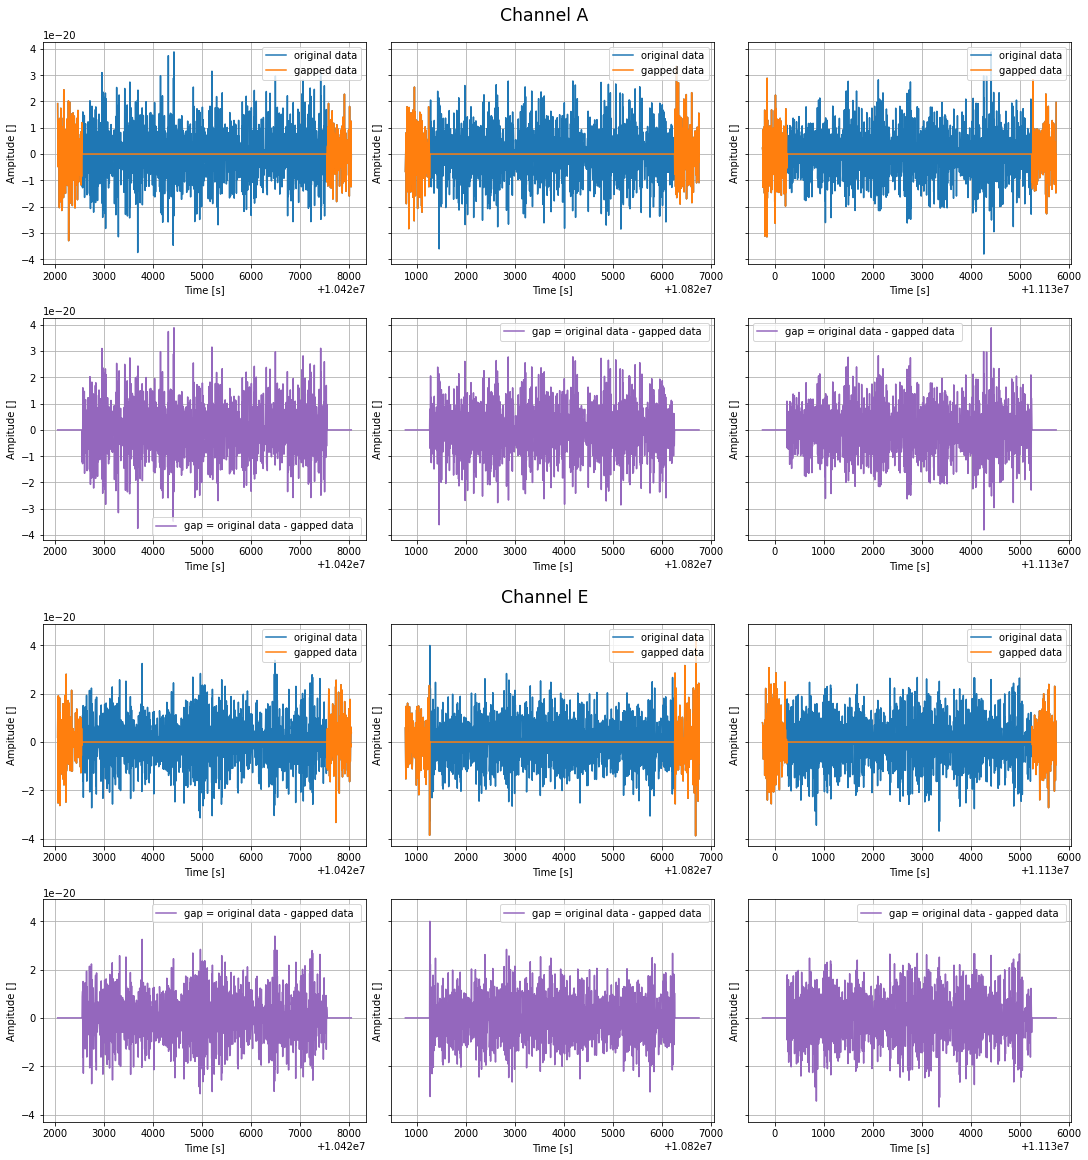

In [35]:
view_gaps(ts = downavg['t'],
          ys = [[downavg[names] for names in downavg.dtype.names[1:]]],
          yg = [data_masked[names] for names in downavg.dtype.names[1:]],
          maskinfo = maskinfo, channels = ['A', 'E'],
          labels=['original data'])

#### 4.1.3 Set up PSD Spritz noise model

In [36]:
from fillgaps import LDCModelPSD, LDCCorrectedModelPSD

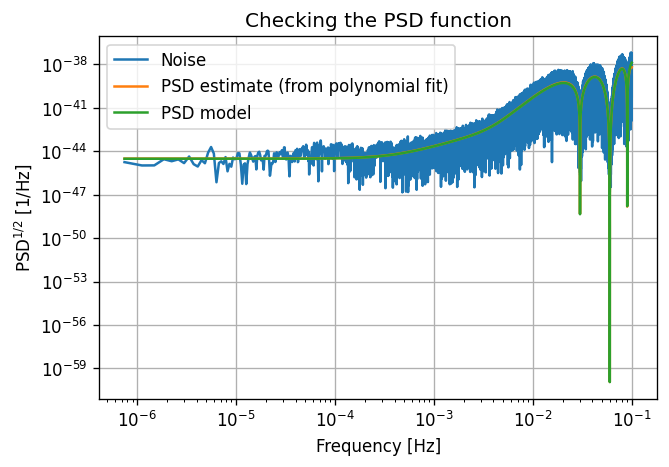

In [37]:
# define tdi names
names = ['A', 'E', 'T']
# create empty arrays
psd_estimate=[]
psd_estimate_gaps=[]
# evaluate fft and periodograms
fdatan_da, psddatan_da, fftscalefac_da = generate_freq_data(downavg)
fdatan_m, psddatan_m, fftscalefac_m = generate_freq_data(data_masked)
#evaluate psd model
Nmodel = get_noise_model(noise_model, fdatan_da['f'])
for tdi in names:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_da['f'][1:])
# perform PSD estimation

# tdi = 'A'
# x = psddatan_m['f'][1:]
# y = np.log(psddatan_m[tdi][1:]/S[tdi])
# pf = np.polyfit(x,y,5)
# psdmodel.fit_lsqr(y)

pf = np.array([-2.06121949e+06,  4.20988173e+05, -2.88082710e+04,  7.11239347e+02,
       -3.23216923e+00,  1.02536420e+00])
poly = np.poly1d(pf)
# Plot data against PSD
fig, ax = plt.subplots(dpi=120)
ax.set_title(r"Checking the PSD function")
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
ax.loglog(psddatan_da['f'][1:], (psddatan_m['A'][1:]), label="Noise")
ax.loglog(psddatan_da['f'][1:], np.abs(poly(psddatan_m['f'][1:])*S['A']), label="PSD estimate (from polynomial fit)")
ax.loglog(psddatan_da['f'][1:], S['A'], label="PSD model")
ax.grid()
plt.legend()
plt.show()
# np.abs(spl(psddatan_da['f'][1:]))

Let's take a look at the model w.r.t downaveraged data.

#### 4.1.5. Perform data imputation

Let's start by creating the imputation iterative step.

The imputation script is structured as follows:

    # generate the boolean mask of gaps
    maskinfo = fill_gaps.construct_gap_mask(ndata,
                                  n_gaps = 3,
                                  gap_length = 100,
                                  verbose = True)
    mask = maskinfo['mask']
    # for residual 'signal' is zero
    # where the complete data are y = s + n 
    s = np.zeros(len(mask)) 
    y_masked = mask * y
    # here we declare the psd class
    #### psd_cls = ....
    # initialize the imputation class
    imp_cls = datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=50*fs, nb=50*fs)
    # Initialize the (reconstructed) data residuals
    imp_cls.compute_offline() ### this was the line that was missing and that triggers an error when starting with psd_cls = PSDSpline(...)
    y_res = y_masked
        for i in range(n_iter):
            # here we might have a step for updating the PSD with updated y_res data
            #### psd_cls = .... update
            # Pass the updated PSD model to the imputation class
            imp_cls.update_psd(psd_cls)
            # Re-compute of PSD-dependent terms
            imp_cls.compute_offline()
            # Imputation of missing data by randomly drawing from their conditional distribution
            y_res = imp_cls.impute(y_masked, draw=True)

(0.0, 100.0)

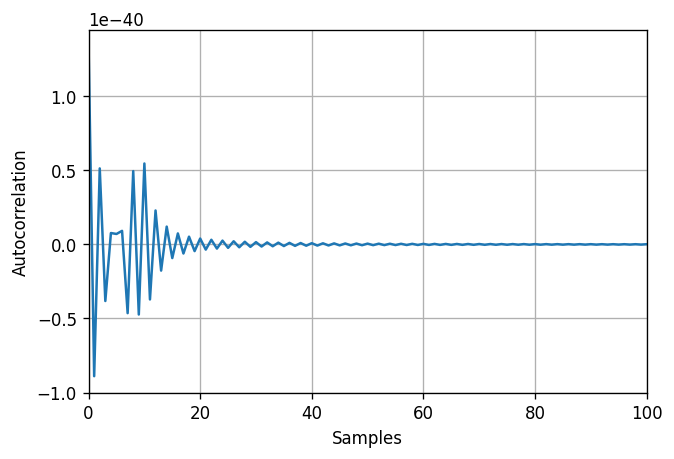

In [32]:
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# set up flags and variables
mask = maskinfo['mask']
PSD_CORRECTION = False
data_rec = data_masked.copy()
    
# instantiate the PSD noise class
if PSD_CORRECTION:
    for tdi in names:
        psd_cls.append(LDCCorrectedModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi, polyfit = poly))
else:
    for tdi in names:
        psd_cls.append(LDCModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
    
# look at the psd autocorrelation to assess the width of the nearest region
fig, ax = plt.subplots(1, 1, dpi=120)
ax.plot(psd_cls[0].calculate_autocorr(ndata))
ax.grid()
ax.set_xlabel('Samples')
ax.set_ylabel('Autocorrelation')
ax.set_xlim([0, 100])    

In [33]:
# Perform data imputation
### NB this can be streamlined a little bit more and/or transformed into a function 
for tdi in range(len(names)):
    y_masked = data_masked[names[tdi]]
    s = np.zeros(len(mask))  #for residual 'signal' is zero
    # instantiate imputation class
    imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='nearest', na=50, nb=50)]
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(y_masked).T) # (ymasked - s)   
    t1 = time.time()
#     imp_cls[tdi].update_psd(psd_cls[tdi])
    # Re-compute of PSD-dependent terms
    imp_cls[tdi].compute_offline()
    # Imputation of missing data by randomly drawing from their conditional distribution
    y_res = imp_cls[tdi].impute(y_masked, draw=True)
    # Update the data residuals
    t2 = time.time()
    print("The imputation / PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))
    data_rec[names[tdi]] = y_res

Computation of autocovariance + PSD took 0.3693230152130127
The imputation / PSD estimation for combination A in iteration 2 took 1.6743040084838867
Computation of autocovariance + PSD took 0.3745920658111572
The imputation / PSD estimation for combination E in iteration 2 took 1.6880309581756592
Computation of autocovariance + PSD took 0.4165341854095459
The imputation / PSD estimation for combination T in iteration 2 took 1.7394788265228271


Now let's take a look at each gap after imputation: We're going to compare original, gapped and reconstructed data.

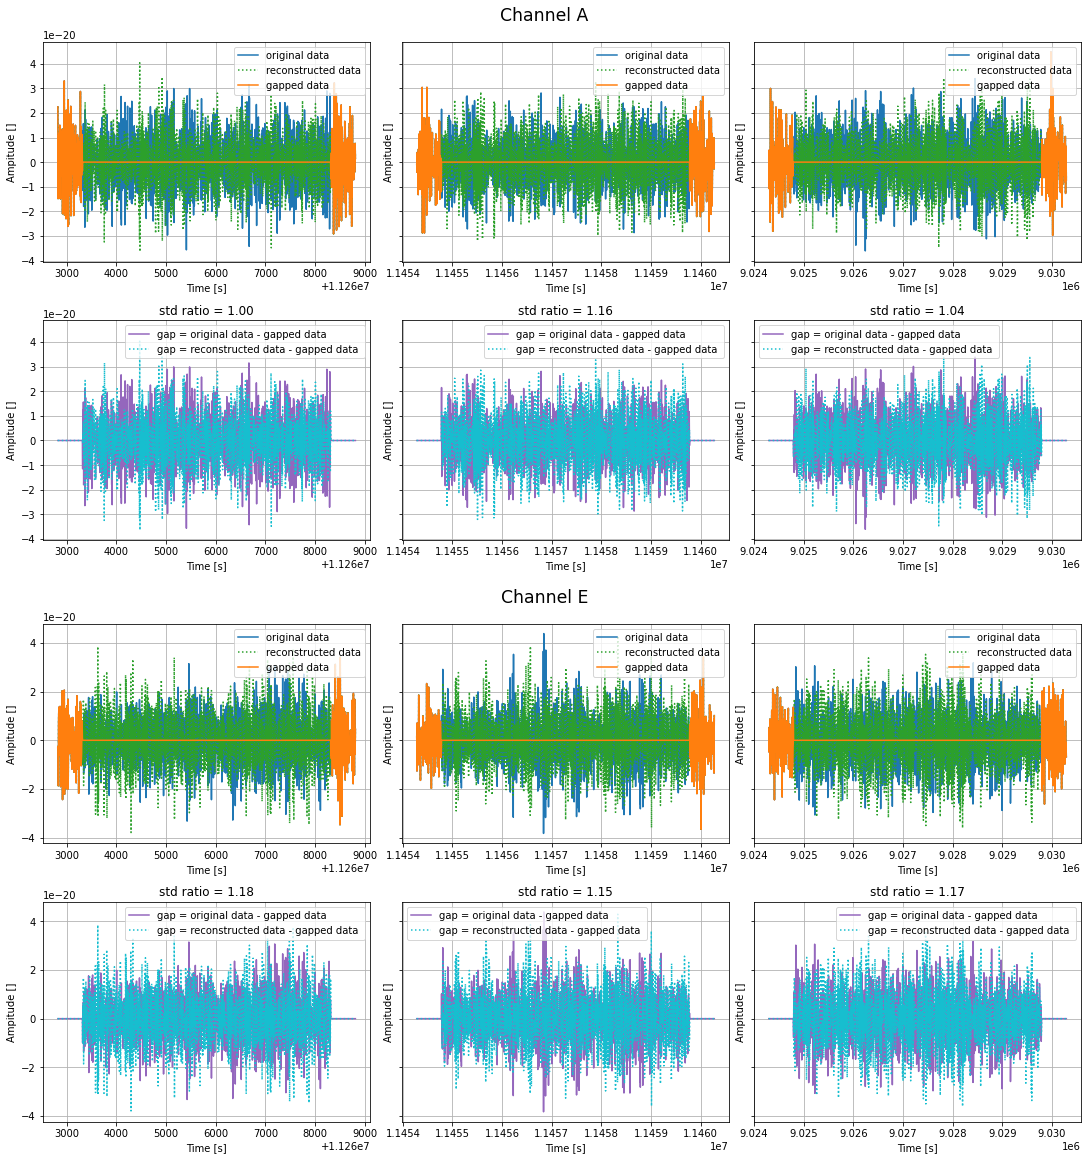

In [34]:
view_gaps(ts = downavg['t'],
          ys = [[downavg[names] for names in downavg.dtype.names[1:]], 
                [data_rec[names] for names in downavg.dtype.names[1:]]],
          yg = [data_masked[names] for names in downavg.dtype.names[1:]],
          maskinfo = maskinfo, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = SAVE, fname = figname)

Regenerate noise models and plot original and reconstructed noise spectra and the distribution of real/imag part of the whitened data.

In [35]:
fdatan_rec, psddata_rec, _ = generate_freq_data(data_rec) 

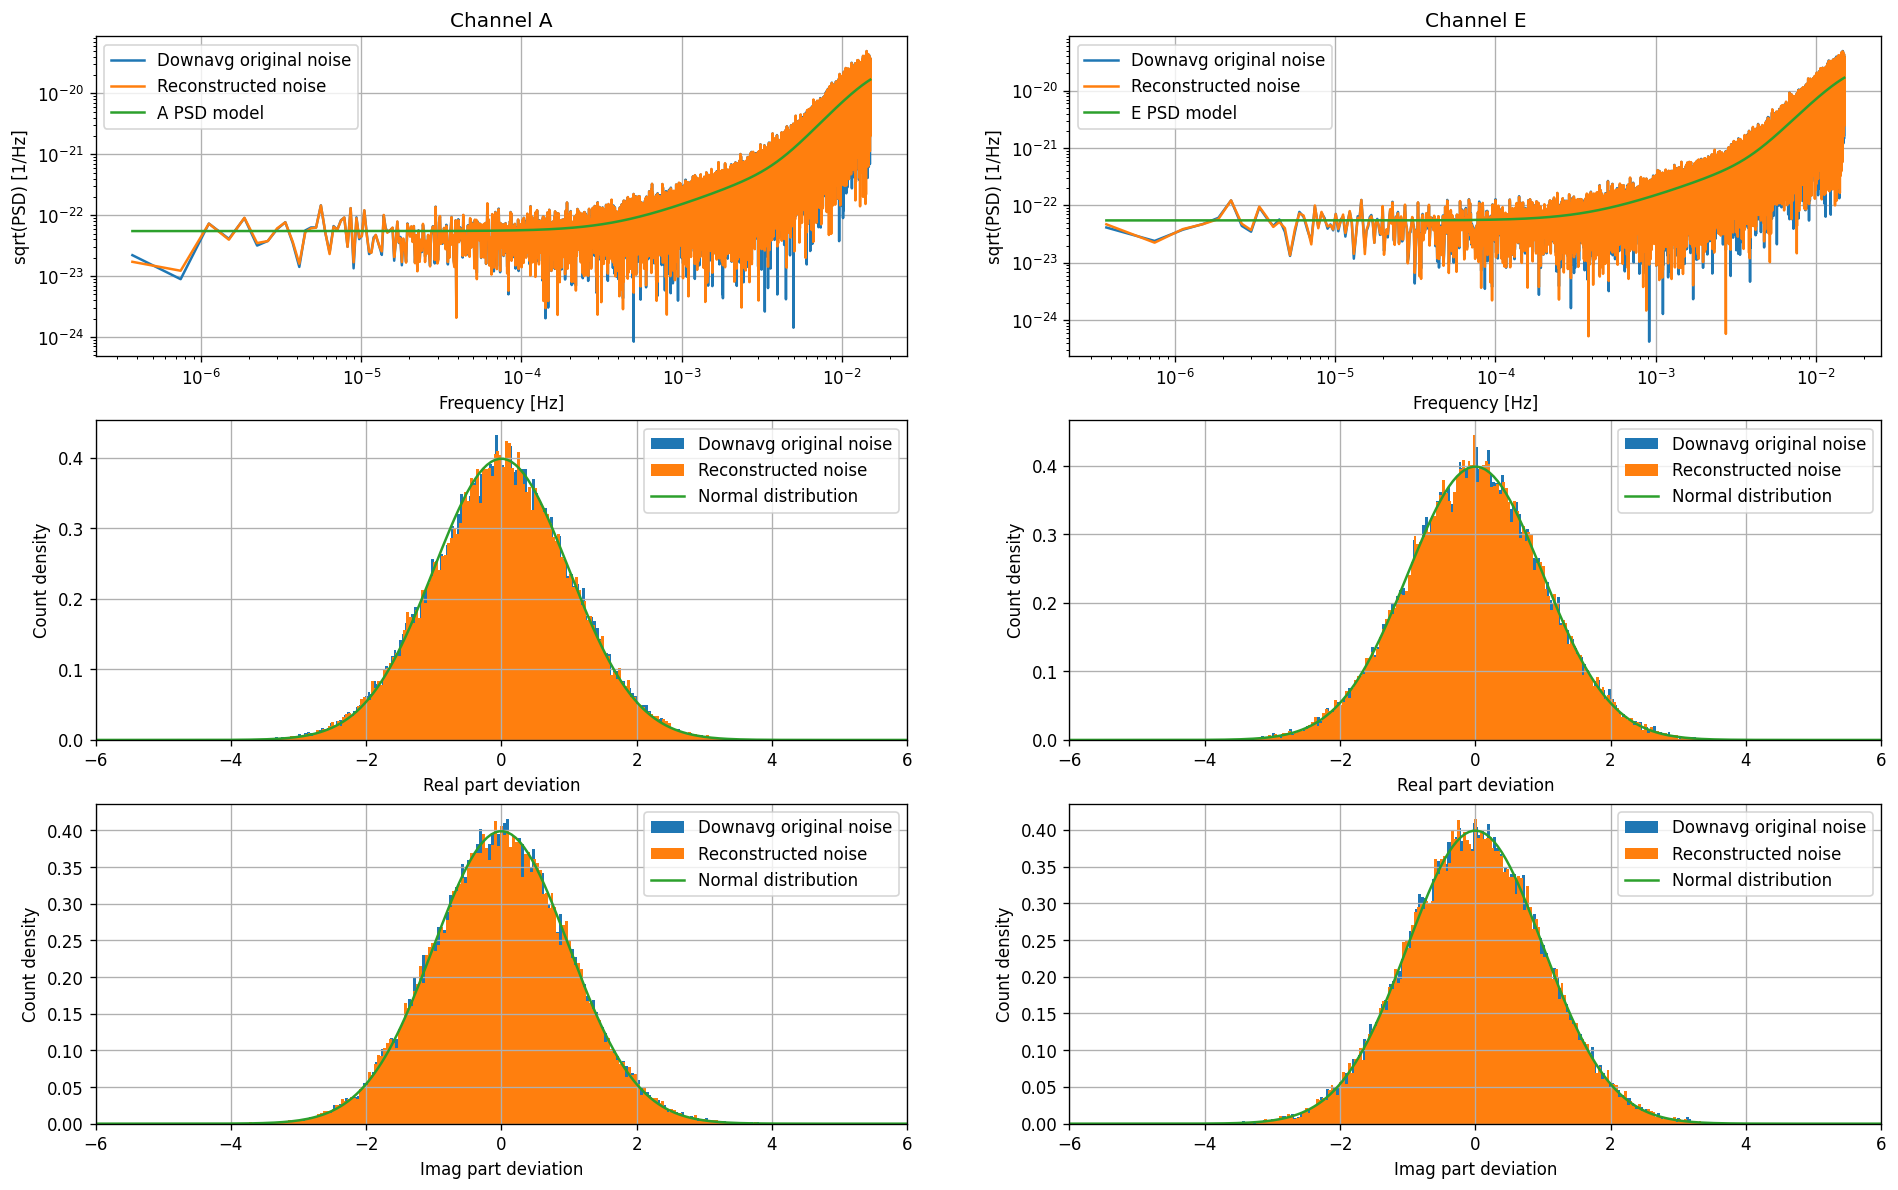

In [36]:
# noise models for A, E, T 
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan_rec['f'])
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_rec['f'])
# plot comparison
plot_compare_spectra_timeseries(data = [downavg, data_rec],#,data_masked], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['Downavg original noise', 'Reconstructed noise'],#, 'gapped data'], 
                                save = SAVE, fname = figname)

#### 4.1.6. Compare PSD noise models for data imputation

Run the analysis again, but this run some tests on the quality of imputation depending on the chosen PSD model:
- Original LDC noise model  $S(f)$
- Corrected LDC noise model $S_{corr}(f) = p(f) S(f)$ where $p(f)$ is a 5th degree polynomial fit to $$\frac{PSD_{exp}(f)}{S(f)}$$

In [37]:
#flag tghat allows us to run or skip this test
TEST = False
PSD_CORRECTION = True
SAVE = False

In [38]:
# create empty arrays for the imputation
std_ratios = []
names = ['A', 'E']
# set up flags and variables
mask = maskinfo['mask']
data_rec = data_masked.copy()
imp_cls = []
psd_cls = []
y_res = []
        
if TEST:
    for i in range(10):
        fignameiter = figname +'_iter'+str(i)
        # instantiate the PSD noise class
        if PSD_CORRECTION:
            for tdi in names:
                psd_cls.append(LDCCorrectedModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi, polyfit = poly))
        else:
            for tdi in names:
                psd_cls.append(LDCModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
        # Perform data imputation
        ### NB this can be streamlined a little bit more and/or transformed into a function 
        for tdi in range(len(names)):
            y_masked = data_masked[names[tdi]]
            s = np.zeros(len(mask))  #for residual 'signal' is zero
            # instantiate imputation class
            imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='nearest', na=50*fs, nb=50*fs)]
            # Initialize the (reconstructed) data residuals
            y_res = np.squeeze(np.array(y_masked).T) # (ymasked - s)   
            t1 = time.time()
            imp_cls[tdi].update_psd(psd_cls[tdi])
            # Re-compute of PSD-dependent terms
            imp_cls[tdi].compute_offline()
            # Imputation of missing data by randomly drawing from their conditional distribution
            y_res = imp_cls[tdi].impute(y_masked, draw=True)
            # Update the data residuals
            t2 = time.time()
            print("The imputation / PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))
            data_rec[names[tdi]] = y_res

        std = view_gaps(ts = downavg['t'],
                  ys = [[downavg[names] for names in downavg.dtype.names[1:]], 
                        [data_rec[names] for names in downavg.dtype.names[1:]]],
                  yg = [data_masked[names] for names in downavg.dtype.names[1:]],
                  maskinfo = maskinfo, channels = ['A', 'E'],
                  labels=['original data', 'reconstructed data', 'gapped data'],
                  save = SAVE, fname = fignameiter)
        std_ratios += [list(std)]

        fdatan_rec, psddata_rec, _ = generate_freq_data(data_rec) 

    #     noise models for A, E, T 
        noise_model = "spritz"
        S = {}
        Nmodel = get_noise_model(noise_model, fdatan_rec['f'])
        for tdi in ['A', 'E', 'T']:
            S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_rec['f'])
    #     plot comparison
        plot_compare_spectra_timeseries(data = [downavg, data_rec], 
                                        noise_models = [S.get(key) for key in ['A','E']],
                                        fmax = 1.5e-2,
                                       labels = ['Downavg original noise', 'Reconstructed noise'], save = SAVE, fname = fignameiter)

In [39]:
from fillgaps import std_ratio_eval

In [40]:
TEST = False

In [41]:
if TEST:
    for PSD_CORRECTION in [False, True]:
        for i in range(500):
            fignameiter = figname +'_iter'+str(i)
            # instantiate the PSD noise class
            if PSD_CORRECTION:
                for tdi in names:
                    psd_cls.append(LDCCorrectedModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi, polyfit = poly))
            else:
                for tdi in names:
                    psd_cls.append(LDCModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))


            # Perform data imputation
            ### NB this can be streamlined a little bit more and/or transformed into a function 
            for tdi in range(len(names)):
                y_masked = data_masked[names[tdi]]
                s = np.zeros(len(mask))  #for residual 'signal' is zero
                # instantiate imputation class
                imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='nearest', na=50*fs, nb=50*fs)]
                # Initialize the (reconstructed) data residuals
                y_res = np.squeeze(np.array(y_masked).T) # (ymasked - s)   
                t1 = time.time()
        #         imp_cls[tdi].update_psd(psd_cls[tdi])
                # Re-compute of PSD-dependent terms
                imp_cls[tdi].compute_offline()
                # Imputation of missing data by randomly drawing from their conditional distribution
                y_res = imp_cls[tdi].impute(y_masked, draw=True)
                # Update the data residuals
                t2 = time.time()
                print("The imputation / PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))
                data_rec[names[tdi]] = y_res

            std = std_ratio_eval(ts = downavg['t'],
                      ys = [[downavg[names] for names in downavg.dtype.names[1:]], 
                            [data_rec[names] for names in downavg.dtype.names[1:]]],
                      yg = [data_masked[names] for names in downavg.dtype.names[1:]],
                      maskinfo = maskinfo, channels = ['A', 'E'])
            std_ratios += [list(std)]
        if PSD_CORRECTION:
            ratiofname = 'data/std_ratios_original.npy'
        else: 
            ratiofname = 'data/std_ratios_corrected.npy'
        names = ['A', 'E']
        gap={}
        gap['A'] = []
        gap['E'] = []
        for i in range(len(std_ratios)):
            for j in range(len(std_ratios[i])): 
                gap[names[j]] += [std_ratios[i][j]]
        np.save(ratiofname, gap)

    else:
        gap_original = np.load('data/std_ratios_original.npy', allow_pickle='TRUE').item()
        gap_corrected = np.load('data/std_ratios_corrected.npy', allow_pickle='TRUE').item()

Plot the histogram of standard deviation ratio

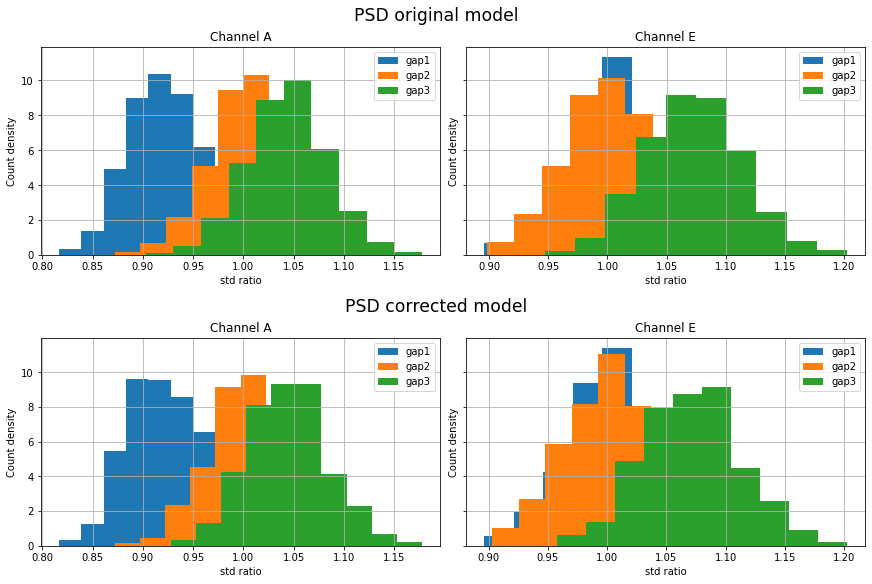

In [42]:
psdmodel = ['original', 'corrected']
gapfname = ['data/std_ratios_' + s + '.npy' for s in psdmodel]

# create figure
fig = plt.figure(figsize=(12,8),constrained_layout=True)
#     fig, axs = plt.subplots(nchan*2,n,figsize=[6.4*n,4.8*nchan*2],squeeze=False)
# create 3x1 subfigures for each channel
subfigs = fig.subfigures(nrows = len(psdmodel), ncols = 1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'PSD {psdmodel[row]} model', size = 'xx-large')
    # create 2xn subplots per subfig
    axs = subfig.subplots(nrows = 1, ncols = len(names), sharey=True)    
# fig, axs = plt.subplots(len(psdmodel),len(names), figsize=(12,8), dpi=120)
# for row in range(len(psdmodel)):
    gap = np.load(gapfname[row], allow_pickle='TRUE').item()
    for i in range(len(names)):
        ax = axs[i]
        ax.set_title('Channel '+names[i])
        k = 0
        for j in np.array(gap[names[i]]).T:
            k +=1
            ax.hist(j, label = 'gap'+str(k), density = True)
            ax.legend()
            ax.grid()
            ax.set_xlabel('std ratio')
            ax.set_ylabel('Count density')
            
fig.savefig('figures/nodownavg_3gaps_1000length_stdratio_distribution.png', dpi = 120, bbox_inches='tight', facecolor='white')

#### 4.1.6 Perform data imputation with `PCG` method and compare it to the `nearest` method




In [43]:
figname = 'figures/nodownavg_'+str(n_gaps)+'gaps_'+str(gap_length)+'length'+'_PCG_psd'
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# set up flags and variables
mask = maskinfo['mask']
PSD_CORRECTION = False
data_rec = data_masked.copy()
names = ['A', 'E']
    
# instantiate the PSD noise class
if PSD_CORRECTION:
    figname = figname + 'corrected' 
    for tdi in names:
        psd_cls.append(LDCCorrectedModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi, polyfit = poly))
else:
    figname = figname + 'original' 
    for tdi in names:
        psd_cls.append(LDCModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))    
    
# Perform data imputation
### NB this can be streamlined a little bit more and/or transformed into a function 
for tdi in range(len(names)):
    y_masked = data_masked[names[tdi]]
    s = np.zeros(len(mask))  #for residual 'signal' is zero
    # instantiate imputation class
    imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='PCG', na=100*fs, nb=100*fs)]
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(y_masked).T) # (ymasked - s)   
    t1 = time.time()
    # Re-compute of PSD-dependent terms
    imp_cls[tdi].compute_offline()
    # Imputation of missing data by randomly drawing from their conditional distribution
    y_res = imp_cls[tdi].impute(y_masked, draw=True)
    # Update the data residuals
    t2 = time.time()
    print("The imputation / PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))
    data_rec[names[tdi]] = y_res

Computation of autocovariance + PSD took 0.3459479808807373
Build preconditionner...
Preconditionner built.
illegal input or breakdown.
Value of || A * x - b ||/||b|| at exit:
1.0
The imputation / PSD estimation for combination A in iteration 1 took 26.828397035598755
Computation of autocovariance + PSD took 0.3149600028991699
Build preconditionner...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_33029/2936327160.py", line 35, in <module>
    y_res = imp_cls[tdi].impute(y_masked, draw=True)
  File "/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/bayesdawn-0.1.0-py3.10.egg/bayesdawn/datamodel.py", line 517, in impute
    return self.draw_missing_data(y, draw=draw)
  File "/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/bayesdawn-0.1.0-py3.10.egg/bayesdawn/datamodel.py", line 550, in draw_missing_data
    self.compute_preconditioner()
  File "/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/bayesdawn-0.1.0-py3.1

TypeError: object of type 'NoneType' has no len()

Now let's take a look at each gap after imputation: We're going to compare original, gapped and reconstructed data.

In [ ]:
view_gaps(ts = downavg['t'],
          ys = [[downavg[names] for names in downavg.dtype.names[1:]], 
                [data_rec[names] for names in downavg.dtype.names[1:]]],
          yg = [data_masked[names] for names in downavg.dtype.names[1:]],
          maskinfo = maskinfo, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = SAVE, fname = figname)

Regenerate noise models and plot original and reconstructed noise spectra and the distribution of real/imag part of the whitened data.

In [ ]:
fdatan_rec, psddata_rec, _ = generate_freq_data(data_rec) 

In [ ]:
# noise models for A, E, T 
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan_rec['f'])
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_rec['f'])
# plot comparison
plot_compare_spectra_timeseries(data = [downavg, data_rec], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['Downavg original noise', 'Reconstructed noise'], 
                                save = SAVE, fname = figname)

### 4.2. Gap imputation on `n` data with long gaps used in Spritz
We'll be using the `datang` dataset, containing the Sprtiz noise gapped data.

We also need to generate the Spritz gap mask.


In [ ]:
from fillgaps import get_ldc_gap_mask

In [ ]:
np.vsplit(spritzgaps, 2)

In [ ]:
gapstarts,gapends = np.vsplit(spritzgaps, 2)


In [ ]:
gapstarts.shape

In [ ]:
mask = np.ones(datang.shape[0])
ndata = datang.shape[0]

spritzgaps = get_ldc_gap_mask(dataobs, mode='index')
gapstarts,gapends= np.vsplit(spritzgaps, 2)

for k in range(gapstarts.shape[1]):
    mask[gapstarts.reshape((2))[k]:gapends.reshape((2))[k]]=0

spritzmask = {'mask': mask,
              'starts': gapstarts.reshape((2)),
              'ends': gapends.reshape((2))}

figname = 'figures/nodownavg_spritzgaps'

In [ ]:
spritzgaps[0][0]

In [ ]:
fig,ax = plt.subplots(1,1,dpi=120)
# ax.plot(maskinfo['mask'])
ax.plot(datan['t'],spritzmask['mask'])
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Spritz gap mask')

In [ ]:
data_masked_spritz = datan.copy()
for tdi in datang.dtype.names[1:]:
    data_masked_spritz[tdi] = spritzmask['mask'] * datan[tdi]
    
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]]],
          yg = [data_masked_spritz[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data'], nwing = 1000)

In [ ]:
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# set up flags and variables
mask = spritzmask['mask']
PSD_CORRECTION = False
datang_rec = data_masked_spritz.copy()
    
# instantiate the PSD noise class
if PSD_CORRECTION:
    for tdi in names:
        psd_cls.append(LDCCorrectedModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi, polyfit = poly))
else:
    for tdi in names:
        psd_cls.append(LDCModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
    
# look at the psd autocorrelation to assess the width of the nearest region
fig, ax = plt.subplots(1, 1, dpi=120)
ax.plot(psd_cls[0].calculate_autocorr(ndata))
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Autocorrelation')
ax.set_xlim([0, 100])
    
# Perform data imputation
### NB this can be streamlined a little bit more and/or transformed into a function 
for tdi in range(len(names)):
    y_masked = data_masked_spritz[names[tdi]]
    s = np.zeros(len(mask))  #for residual 'signal' is zero
    # instantiate imputation class
    imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='nearest', na=100, nb=100)]
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(y_masked).T) # (ymasked - s)   
    t1 = time.time()
#     imp_cls[tdi].update_psd(psd_cls[tdi])
    # Re-compute of PSD-dependent terms
    imp_cls[tdi].compute_offline()
    # Imputation of missing data by randomly drawing from their conditional distribution
    y_res = imp_cls[tdi].impute(y_masked, draw=True)
    # Update the data residuals
    t2 = time.time()
    print("The imputation / PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))
    datang_rec[names[tdi]] = y_res

In [ ]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [data_masked_spritz[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = SAVE, fname = figname, nwing=1000)

In [ ]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

In [ ]:
# noise models for A, E, T 
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan_rec['f'])
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_rec['f'])
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['original noise', 'Reconstructed noise'], 
                                save = SAVE, fname = figname)

## 5. Detect and mask glitches

In [ ]:
dt = dataobs['t'][1]-dataobs['t'][0]
fs = 1.0/dt

In [ ]:
 # Low-pass filter the data to better see the glitches
def BH_lowpass(data, t_win=100,t_sam=5,fs=10):
    """
    BH_lowpass, lowpass data convolving with a BH92 windowing function.
    data:  tuple of synchronously sampled time series
    t_win: window length, controls cut frequency
    t_sam: output sampling time
    fs:    input sampling frequency
    L Sala, December 2021
    modified by E Castelli, Sept 2022
    """
    names = data.dtype.names[1:]
    dt = 1/fs
    step_win = np.intc(t_win*fs)
    step_sam = np.intc(t_sam*fs)
    assert t_sam>=dt, 'Watch out, do not upsample your data.'
    assert np.isclose(t_sam*fs,int(t_sam*fs),rtol=1e-5), 'Downsampling time must be multiple of sampling time.'
    assert np.isclose(t_win*fs,int(t_win*fs),rtol=1e-5), 'Windowing time must be multiple of sampling time.'
    assert np.isclose(step_win/step_sam,int(step_win/step_sam),rtol=1e-5), 'Watch out, t_win must be multiple of t_sam.'
    
    dtarr = np.diff(data['t'])
    assert np.isclose(dtarr[0],dt,rtol=1e-5), 'Aaargh, sampling frequency is not consistent with data.' #just check fs
    assert np.allclose(dtarr,dt,rtol=1e-5), 'Aaargh, your data are not equally sampled in time.' #just check sampling time

    BHfilt = BH92(step_win) #build filter
    BHarea = np.sum(BHfilt)
    BHfilt = BHfilt/BHarea
    onearray = np.ones(step_win)/step_win

    #apply filter convolving
    outts = [np.convolve(data['t'],onearray,mode='valid')] #just a simple way to get times, computationally more expensive than linspace, but safer
    for tdi in names:
        outts += [np.convolve(data[tdi], BHfilt,  mode='valid')]
    #downsample it
    for i in range(len(outts)):
        outts[i] = outts[i][::step_sam]
    datalp = np.rec.fromarrays(outts, names = ['t', 'A', 'E', 'T'])
    return datalp

def BH92(M:int):
    z = np.arange(0,M)*2*np.pi/M
    return 0.35875 - 0.48829 * np.cos(z) + 0.14128 * np.cos(2*z) - 0.01168 * np.cos(3*z)


In [ ]:
datan_lp = BH_lowpass(dataobs,t_win=100,t_sam=5,fs=0.2)
datan_lp.shape

In [ ]:
plt.figure(figsize=(16, 6))
i1 = 1000
i2 = 1000000
plt.plot(dataobs['t'], dataobs['A'], label='Filtered data')
plt.plot(datan_lp['t'], datan_lp['A'], label='Filtered data')
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
# plt.xlim([gapsstart[0]-1000, gapsend[0]+1000])
# plt.ylim([-1e-20, 1e-20])
plt.grid()
plt.show()

In [ ]:
def detect_glitch_outliers(data, plot = True):
    n = data.dtype.names[1]
    gaps = get_ldc_gap_mask(dataobs, mode='index')
    
    mad = scipy.stats.median_abs_deviation(data[n])
    median = np.median(data[n][0:gaps[0][0]])
    maxval = np.max(np.abs(data[n]))
    peaks, properties = scipy.signal.find_peaks(np.abs(data[n]), height=10*mad, threshold=None, distance=1)

    if plot:
        fig, ax = plt.subplots(1,1,figsize=(8,4),dpi=100)
        ax.plot(data['t'], data[n], label='Filtered data')
        ax.vlines(data['t'][peaks], ymin=-1.1*maxval, ymax=1.1*maxval, color='red', linestyle='dashed', label='Detected outliers')
        ax.set_ylabel('TDI'+n)
        ax.set_xlabel('Time [s]')      
        ax.legend()
        ax.grid()

    return peaks

In [ ]:
peaks = detect_glitch_outliers(datan_lp)
print(type(peaks))

datan_lp['t'][peaks[-1]] - datan_lp['t'][peaks[-2]]
np.diff(datan_lp['t'][peaks])

In [ ]:
def mask_glitches(data, peaks, glitchnum):
    data_mask = np.copy(data)
    glitchlen = int(data['t'][peaks[1]] - data['t'][peaks[0]])

    if type(data) is dict:
        for k in data_mask.keys():
            for tdi in data_mask[k].dtype.names[1:]:
                for pk in peaks[:2*glitchnum]:
                    data_mask[k][tdi][pk-glitchlen:pk+glitchlen] = 0.0
    else:
        print(data_mask.dtype)
        for tdi in data_mask.dtype.names[1:]:
            print(tdi)
            for pk in peaks[:2*glitchnum]:
                data_mask[tdi][pk-glitchlen:pk+glitchlen] = 0.0

    return data_mask

In [ ]:
 # Turning glitches into gaps
dataobs_mask = np.copy(dataobs)
glitchnum=3
for tdi in dataobs_mask.dtype.names[1:]:
    for pk in peaks[:2*glitchnum]:
        dataobs_mask[tdi][pk-20:pk+50] = 0.0
        


In [ ]:
dataobs_mask = mask_glitches(data = dataobs, 
                             peaks = peaks, 
                             glitchnum = 3)

dataobs_mask

# fdataobs, psddataobs, fftscalefac = generate_freq_data(dataobs)
# fdataobs_mask, psddataobs_mask, fftscalefac_mask = generate_freq_data(dataobs_mask)

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.plot(dataobs['t'], dataobs['A'], label='Observed data', rasterized=True)
plt.plot(dataobs['t'], dataobs_mask['A'], label='Observed data, glitches set to zero', rasterized=True)

plt.ylabel("TDI X")
plt.xlabel("Time [s]")
# plt.xlim([0.95e7, 0.956e7])
plt.ylim([-1e-19, 1e-19])
plt.grid()
plt.legend(loc='upper right')

plt.subplot(212)
plt.loglog(psddataobs['f'], np.sqrt(psddataobs['A']), label='Observed data', rasterized=True)

plt.loglog(psddataobs['f'], np.sqrt(psddataobs_mask['A']), label='Observed data, glitches set to zero', rasterized=True)
plt.ylabel("$\sqrt{PSD X}$")
plt.xlabel("Freq [Hz]")
plt.grid()
# plt.xlim([1e-4, 1e-1])
plt.legend(loc='lower left')

In [ ]:
fdatas, psddatas, fftscalefac = generate_freq_data(datas)

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.plot(dataobs['t'], dataobs_mask['A'], label='Observed data, glitches set to zero', rasterized=True)
plt.plot(dataobs['t'], datas['A'], label='MBHB data', rasterized=True)

plt.ylabel("TDI X")
plt.xlabel("Time [s]")
# plt.xlim([0.95e7, 0.951e7])
# plt.ylim([-1e-19, 1e-19])
plt.legend(loc='upper right')

plt.subplot(212)
plt.loglog(psddataobs['f'], np.sqrt(psddataobs_mask['A']), label='Observed data, glitches set to zero', rasterized=True)
plt.loglog(psddatas['f'], np.sqrt(psddatas['A']), label='MBHB data', rasterized=True)

# plt.loglog(f, np.sqrt(psdX_noiseless), label='VGB signal', rasterized=True)
# plt.loglog(fxx[fxx>0], np.sqrt(npsd), label='Theoretical noise PSD (without artefacts)', rasterized=True)
plt.ylabel("$\sqrt{PSD X}$")
plt.xlabel("Freq [Hz]")
# plt.xlim([1e-4, 1e-1])
plt.legend(loc='lower left')

plt.show()

## 5. Gap imputation on `n + s` data 

## 5. Analysis of Spritz gapped data